# 📘 CUSTOMER RETENTION & COHORT ANALYSIS
### Understanding Repeat Behavior & Revenue Quality

**Role context:** Senior Data Analyst  
**Tools:** DuckDB (SQL), Python  
**Dataset:** Sample Superstore (public dataset)


## A. Executive Summary
This analysis evaluates customer retention patterns using cohort analysis.
The objective is to understand repeat behavior, revenue quality from new versus returning customers,
and identify which customer cohorts contribute sustainable long-term value.

Insights from this analysis support decisions related to promotions, loyalty strategy,
and customer lifecycle management.




## ⏭️ 0. Data Preparation (SQL via DuckDB)

In [3]:
import pandas as pd
import os

path_folder = r"C:\Users\yohan\workstation\fore\Promo Effectiveness Analysis"
files = os.listdir(path_folder)
file_target = next((f for f in files if f.endswith('.csv')), None)

if file_target:
    full_path = os.path.join(path_folder, file_target)
    
    try:
        # Percobaan 1: utf-8 (default)
        df = pd.read_csv(full_path)
    except UnicodeDecodeError:
        try:
            # Percobaan 2: latin1 (umum untuk file Windows/Excel)
            print("UTF-8 gagal, mencoba encoding latin1...")
            df = pd.read_csv(full_path, encoding='latin1')
        except UnicodeDecodeError:
            # Percobaan 3: ISO-8859-1
            print("latin1 gagal, mencoba encoding ISO-8859-1...")
            df = pd.read_csv(full_path, encoding='ISO-8859-1')

    print(f"\nDataFrame '{file_target}' berhasil dimuat!")
    print(df.head())
    
    # Simpan dataframe ke variabel global untuk analisis selanjutnya
    # %store df # Jika di Jupyter, ini berguna
else:
    print("\nTidak ada file CSV yang ditemukan.")

UTF-8 gagal, mencoba encoding latin1...

DataFrame 'Sample - Superstore.csv' berhasil dimuat!
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

In [15]:
data_prep = df
con = duckdb.connect()

con.register("data_prep", data_prep)


## ⏭️ 1. CUSTOMER BASELINE (NEW vs RETURNING)
“How much of our revenue comes from returning customers versus new customers?”

In [16]:
query = """
WITH first_order AS (
    SELECT
        "Customer ID" AS CUSTOMER_ID,
        MIN("Order Date") AS FIRST_ORDER_DATE
    FROM data_prep
    GROUP BY "Customer ID"
)

SELECT
    CASE
        WHEN d."Order Date" = f.FIRST_ORDER_DATE THEN 'New'
        ELSE 'Returning'
    END AS CUSTOMER_TYPE,
    COUNT(DISTINCT d."Customer ID") AS CUSTOMERS,
    ROUND(SUM(d.Sales), 2) AS GMV,
    ROUND(SUM(d.Profit), 2) AS PROFIT,
    ROUND(SUM(d.Profit) / SUM(d.Sales) * 100, 2) AS MARGIN_PCT
FROM data_prep d
JOIN first_order f
    ON d."Customer ID" = f.CUSTOMER_ID
GROUP BY CUSTOMER_TYPE
ORDER BY CUSTOMER_TYPE
"""
customer_baseline = con.execute(query).df()
customer_baseline


,CUSTOMER_TYPE,CUSTOMERS,GMV,PROFIT,MARGIN_PCT
0,New,793,432992.70,59183.49,13.67
1,Returning,781,1864208.16,227213.54,12.19


### Insight

Returning customers are the primary revenue driver, contributing the majority of GMV despite representing a similar customer count compared to new customers. This indicates that repeat purchases, rather than acquisition volume, drive overall business performance.

New customers deliver a slightly higher margin percentage, suggesting lower discount exposure on first purchases. However, their total GMV contribution remains significantly smaller due to lower purchase frequency.

Overall, business growth is more dependent on retaining customers and increasing repeat behavior rather than continuously acquiring new users.

🎯 BUSINESS TAKEAWAY

 - Acquisition ≠ growth by itself
 - Retention = scale
 - Margin gap is behavioral, not pricing-driven

“Revenue growth is retention-led rather than acquisition-led.”


## ⏭️ 2. BASIC RETENTION RATE
“How much of our revenue comes from returning customers versus new customers?”

“How many customers actually come back?”
simple repeat rate (≥2 orders).

In [19]:
query = """
SELECT
    COUNT(DISTINCT CUSTOMER_ID) AS TOTAL_CUSTOMERS,
    COUNT(DISTINCT CASE WHEN order_count > 1 THEN CUSTOMER_ID END) AS RETURNING_CUSTOMERS,
    ROUND(
        COUNT(DISTINCT CASE WHEN order_count > 1 THEN CUSTOMER_ID END)
        * 100.0
        / COUNT(DISTINCT CUSTOMER_ID),
        2
    ) AS RETENTION_RATE_PCT
FROM (
    SELECT
        "Customer ID" AS CUSTOMER_ID,
        COUNT(DISTINCT "Order ID") AS order_count
    FROM data_prep
    GROUP BY "Customer ID"
) t
"""

retention_rate = con.execute(query).df()
retention_rate


,TOTAL_CUSTOMERS,RETURNING_CUSTOMERS,RETENTION_RATE_PCT
0,793,781,98.49


### Insight

The overall retention rate is extremely high at 98.49%, indicating that nearly all customers have made more than one purchase.

This suggests a highly repeat-driven dataset, where customer behavior is dominated by returning users rather than one-time buyers. As a result, revenue stability is strong, but acquisition impact is relatively limited.

However, such a high retention rate should be interpreted carefully. This pattern is likely influenced by the nature of the dataset (e.g., B2B-like purchasing, recurring demand, or historical data aggregation) rather than typical consumer behavior.

Despite this, retention analysis remains valuable for understanding purchase frequency, cohort longevity, and revenue concentration over time.

Note:
The unusually high retention rate reflects the structure of the dataset rather than a realistic consumer retention benchmark. The cohort analysis below focuses on relative behavior between cohorts instead of absolute retention levels.



## ⏭️ 3. COHORT SETUP (FOUNDATION)

Cohort definition:

- Cohort month = first order month
- Activity month = order month
- Cohort index = months since first purchase

In [24]:
query = """
WITH first_order AS (
    SELECT
        "Customer ID" AS CUSTOMER_ID,
        DATE_TRUNC(
            'month',
            MIN(STRPTIME("Order Date", '%m/%d/%Y'))
        ) AS COHORT_MONTH
    FROM data_prep
    GROUP BY "Customer ID"
),

orders_enriched AS (
    SELECT
        d."Customer ID" AS CUSTOMER_ID,
        DATE_TRUNC(
            'month',
            STRPTIME(d."Order Date", '%m/%d/%Y')
        ) AS ORDER_MONTH,
        f.COHORT_MONTH
    FROM data_prep d
    JOIN first_order f
        ON d."Customer ID" = f.CUSTOMER_ID
)

SELECT
    CUSTOMER_ID,
    COHORT_MONTH,
    ORDER_MONTH,
    DATE_DIFF('month', COHORT_MONTH, ORDER_MONTH) AS COHORT_INDEX
FROM orders_enriched
ORDER BY CUSTOMER_ID, ORDER_MONTH
"""

cohort_base = con.execute(query).df()
cohort_base.head(10)


,CUSTOMER_ID,COHORT_MONTH,ORDER_MONTH,COHORT_INDEX
0,AA-10315,2014-03-01,2014-03-01,0
1,AA-10315,2014-03-01,2014-03-01,0
2,AA-10315,2014-03-01,2014-09-01,6
3,AA-10315,2014-03-01,2014-09-01,6
4,AA-10315,2014-03-01,2015-10-01,19
5,AA-10315,2014-03-01,2016-03-01,24
6,AA-10315,2014-03-01,2016-03-01,24
7,AA-10315,2014-03-01,2016-03-01,24
8,AA-10315,2014-03-01,2016-03-01,24
9,AA-10315,2014-03-01,2017-06-01,39


### Insight

Each customer is correctly assigned to a cohort based on the month of their first purchase.
The cohort index accurately measures the number of months since the first transaction.

For example, a customer with a first purchase in March 2014 shows repeat activity at 6, 19, 24, and 39 months,
demonstrating long-term repeat behavior rather than short-term promotional effects.

Multiple rows with the same cohort index indicate multiple transactions within the same month,
which is expected at order-line level and does not affect retention calculations.

This confirms that the cohort foundation is correctly constructed and ready for aggregation.


## ⏭️ 4. COHORT MATRIX (RETENTION TABLE)

“How many customers from each cohort remain active over time?”

Retention definition:
- Active = customer makes ≥1 purchase in that month
- Metric = % of original cohort customers

In [26]:
query = """
WITH cohort_counts AS (
    SELECT
        COHORT_MONTH,
        COUNT(DISTINCT CUSTOMER_ID) AS cohort_size
    FROM cohort_base
    WHERE COHORT_INDEX = 0
    GROUP BY COHORT_MONTH
),

cohort_activity AS (
    SELECT
        COHORT_MONTH,
        COHORT_INDEX,
        COUNT(DISTINCT CUSTOMER_ID) AS active_customers
    FROM cohort_base
    GROUP BY COHORT_MONTH, COHORT_INDEX
)

SELECT
    a.COHORT_MONTH,
    a.COHORT_INDEX,
    ROUND(
        a.active_customers * 100.0 / c.cohort_size,
        2
    ) AS RETENTION_RATE_PCT
FROM cohort_activity a
JOIN cohort_counts c
    ON a.COHORT_MONTH = c.COHORT_MONTH
ORDER BY a.COHORT_MONTH, a.COHORT_INDEX
"""

cohort_retention = con.execute(query).df()
cohort_retention.head(20)


,COHORT_MONTH,COHORT_INDEX,RETENTION_RATE_PCT
0,2014-01-01,0,100.00
1,2014-01-01,1,9.38
2,2014-01-01,3,6.25
3,2014-01-01,4,6.25
4,2014-01-01,6,6.25
5,2014-01-01,7,12.50
6,2014-01-01,8,15.63
7,2014-01-01,9,9.38
8,2014-01-01,10,21.88
9,2014-01-01,11,15.63


### Insight

The cohort retention table shows a sharp drop after the first month, followed by a long tail of recurring activity.
While only a small percentage of customers return consistently in early months, a stable subset continues to repurchase over an extended period.

Retention does not decay monotonically. Several cohorts show reactivation spikes at later intervals (e.g., months 10–12, 18, and beyond),
indicating periodic or project-based purchasing behavior rather than continuous monthly engagement.

This pattern suggests that customers are not retained through habitual frequency,
but through long-term relevance and occasional high-intent return cycles.

Retention quality should therefore be evaluated on longevity and lifetime contribution,
not short-term month-to-month repeat alone.

🎯 BUSINESS MEANING (IMPLICIT)

- it's not subscription behavior
- this is long-cycle repeat business
- Retention value = lifetime depth, not weekly activity



## ⏭️ 5. COHORT HEATMAP (VISUAL STORY)

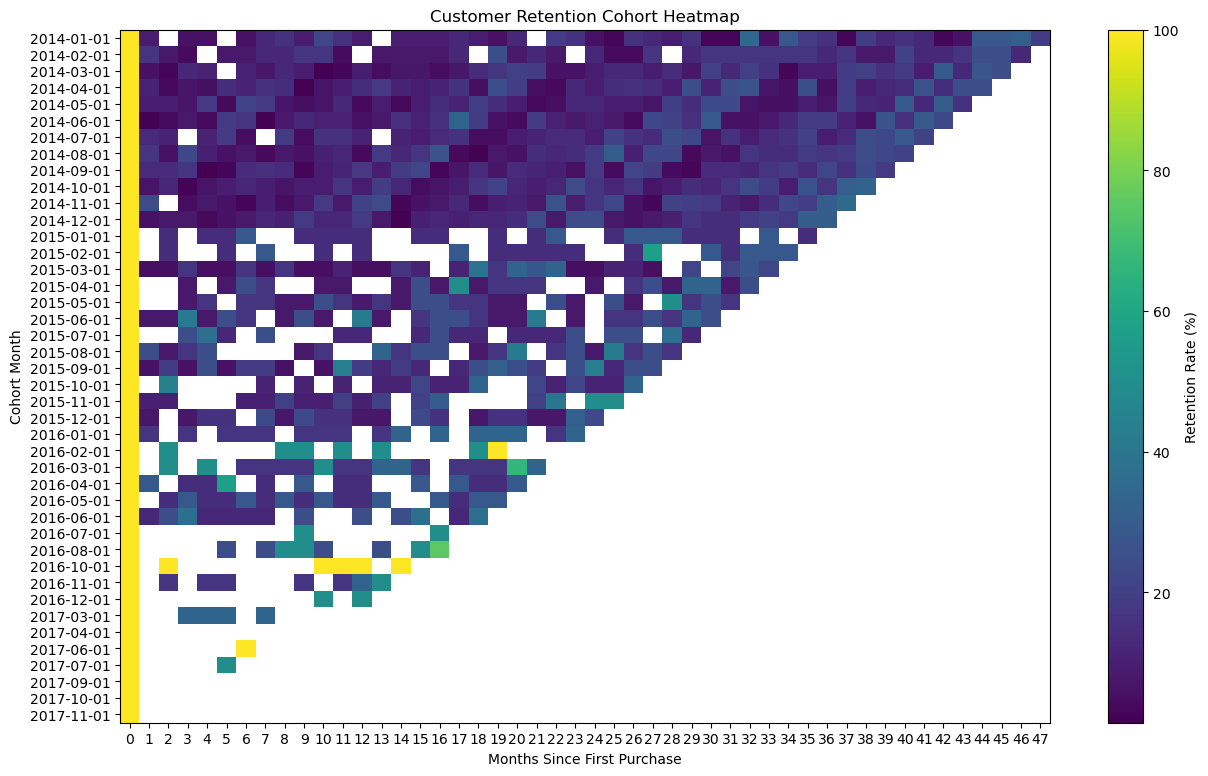

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Pivot cohort table
cohort_pivot = cohort_retention.pivot(
    index='COHORT_MONTH',
    columns='COHORT_INDEX',
    values='RETENTION_RATE_PCT'
)

plt.figure(figsize=(15,9))
plt.imshow(cohort_pivot, aspect='auto')
plt.colorbar(label='Retention Rate (%)')

plt.title('Customer Retention Cohort Heatmap')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')

plt.xticks(
    ticks=range(len(cohort_pivot.columns)),
    labels=cohort_pivot.columns,
    rotation=0
)
plt.yticks(
    ticks=range(len(cohort_pivot.index)),
    labels=cohort_pivot.index.astype(str)
)

plt.show()


### Insight

The cohort heatmap reveals a consistent retention pattern across cohorts, characterized by a sharp early drop followed by a long tail of repeat activity.

Most cohorts experience significant attrition within the first few months, indicating that customers do not exhibit high-frequency repeat behavior. However, a stable subset of customers continues to return over long periods, with visible reactivation spikes even after 12, 24, and 36 months.

Later cohorts show similar behavior patterns despite having shorter observation windows, suggesting that retention dynamics are structurally consistent over time rather than cohort-specific anomalies.

This pattern indicates that customer value is driven by long-term relevance and occasional high-intent repurchases, rather than continuous engagement. Retention success should therefore be measured by longevity and lifetime contribution instead of short-term repeat rates.


🎯 WHAT THIS MEANS
- This is not a subscription model
- This is a long-cycle repeat business
- Customers don't visit often, but they return over the long term
- Retention ≠ weekly activity
- Retention = staying relevant over years

This is a perfect fit for:
- Retail
- Lifestyle
- Premium Coffee / F&B
- App + offline hybrids


## ⏭️ EXECUTIVE RECOMMENDATIONS


1. **Shift Retention Focus from Frequency to Longevity**
   - Retention success should be evaluated based on customer lifetime contribution rather than short-term repeat frequency.
   - KPIs such as Customer Lifetime Value (CLV) and long-term reactivation rates should complement monthly retention metrics.
2. **Prioritize Returning Customer Value**
   - Returning customers contribute the majority of GMV and represent the core revenue engine.
   - Promotions and campaigns should be designed to re-engage existing customers instead of over-investing in acquisition.
3. **Design Reactivation-Based Campaigns**
   - The presence of reactivation spikes suggests opportunities for periodic, event-driven campaigns.
   - Target customers based on time since last purchase (e.g., 6, 12, 24 months) rather than generic mass promotions.
4. **Use Acquisition Strategically, Not Aggressively**
   - New customers generate higher margin initially but contribute less total GMV.
   - Acquisition should focus on quality and long-term fit rather than volume-driven discounting.
5. **Align Loyalty Strategy with Long-Term Engagement**
   - Loyalty programs should reward longevity and cumulative value, not just purchase frequency.
   - This reinforces sustainable retention behavior aligned with observed cohort dynamics.

Overall, sustainable growth is driven by retaining customers over long time horizons, not by maximizing short-term repeat rates.
